In [4]:
import torchvision 
import torch 
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
from time import time
import PIL
import matplotlib.pyplot as plt

In [5]:
def trainModel(lr, epoch_count, train_ratio, val_ratio, train_batch_size, validation_batch_size, test_batch_size, num_classes):
    
    train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), 
    transforms.Resize((70,70)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])
    
    
    #loading and spliting data
    dataset = datasets.ImageFolder('./dataset', transform = train_transforms)
    
    print("Class and Label Ids:",dataset.class_to_idx)
    dataset_size = len(dataset)
    train_set_size = int(dataset_size * train_ratio)
    validation_set_size = int(dataset_size * val_ratio)
    test_set_size = dataset_size - train_set_size - validation_set_size
    
    print("Training set size:", train_set_size)
    print("Validation set size:", validation_set_size)
    print("Test set size:", test_set_size)
    
    
    train_set, validation_set, test_set = torch.utils.data.random_split(dataset, [train_set_size, validation_set_size, test_set_size])
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size = train_batch_size, shuffle=True, drop_last=True)

    validation_loader = torch.utils.data.DataLoader(validation_set, batch_size = validation_batch_size, shuffle=True, drop_last=True)
    
    test_loader = torch.utils.data.DataLoader(test_set, batch_size = test_batch_size, shuffle=True, drop_last=True)
    
    train_loader = [batch for batch in train_loader]
    train_batch_count = len(train_loader)
    print("Traning Set Batch Count:",train_batch_count)
    print("Training Set Batch Size:",train_batch_size)
    
    validation_loader = [batch for batch in validation_loader]
    validation_batch_count = len(validation_loader)
    print("Validation Set Batch Count:",validation_batch_count)
    print("Validation Set Batch Size:",validation_batch_size)
    
    test_loader = [batch for batch in test_loader]
    test_batch_count = len(test_loader)
    print("Test Set Batch Count",test_batch_count)
    print("Test Set Batch Size:",test_batch_size)
    
    print("*************************************************************************************")
    
    
    
    training_loss_list = []
    validation_loss_list = []
    training_accuracy_list = []
    validation_accuracy_list = []
    test_accuracy_list = []
    train_error_list = []
    validation_error_list = []
    test_error_list = []
    
    
    
    def TrueCount(pred, y_true, epoch, batch_id, set_type):
        true_count = 0
        for i in range(pred.size(0)):
            if torch.argmax(pred[i])==torch.argmax(y_true[i]):
                true_count += 1
            else:#yanlış tahmin yaptıysa ve son epochta ise:
                if epoch==epoch_count-1:
                    vector = [batch_id, i, torch.argmax(pred[i]), torch.argmax(y_true[i])]
                    if set_type == "train":
                        train_error_list.append(vector)
                    if set_type == "validation":
                        validation_error_list.append(vector)
                    if set_type == "test":
                        test_error_list.append(vector)
        return true_count    
    
    
    

    class Net(nn.Module):
        def __init__(self,num_classes):
            super().__init__()
            
            self.channel = 8
            self.conv1 = torch.nn.Conv2d(in_channels = 3, out_channels = self.channel, kernel_size = 7) 
            torch.nn.init.xavier_uniform_(self.conv1.weight)
            self.conv2 = torch.nn.Conv2d(in_channels = self.channel, out_channels = self.channel+2, kernel_size = 5)
            torch.nn.init.xavier_uniform_(self.conv2.weight)
            self.conv3 = torch.nn.Conv2d(in_channels = self.channel+2, out_channels = self.channel+7, kernel_size = 3)
            torch.nn.init.xavier_uniform_(self.conv3.weight)
            self.conv4 = torch.nn.Conv2d(in_channels = self.channel+7, out_channels = self.channel+9, kernel_size = 1)
            torch.nn.init.xavier_uniform_(self.conv4.weight)

            self.bn1 = nn.BatchNorm1d(num_features=150)
            
            self.dropout1 = nn.Dropout2d(0.25)
            self.dropout2 = nn.Dropout2d(0.5)
            self.pool = nn.MaxPool2d(2, 2)

            self.beta1 = nn.Linear((self.channel+9)*3*3, 150)
            torch.nn.init.xavier_uniform_(self.beta1.weight)
            self.beta2 = nn.Linear(150, 150)
            torch.nn.init.xavier_uniform_(self.beta2.weight)
            self.beta3 = nn.Linear(150, 150)
            torch.nn.init.xavier_uniform_(self.beta3.weight)
            self.beta4 = nn.Linear(150, num_classes)
            torch.nn.init.xavier_uniform_(self.beta4.weight)
            
            

        def forward(self, X):

            y=self.conv1(X) 
            y=torch.nn.functional.relu(y)
            y=self.pool(y) 
            y=self.conv2(y) 
            y=torch.nn.functional.relu(y)
            y=self.pool(y) 
            y=self.conv3(y) 
            y=torch.nn.functional.relu(y)
            y=self.pool(y) 
            y=self.conv4(y) 
            y=torch.nn.functional.relu(y)
            y=self.pool(y) 
            #y=self.dropout1(y)

            #y = y.view(X.shape[0], self.channel*25*25)
            #print(y.shape)
            y = y.view(X.shape[0], (self.channel+9)*3*3)
            
            y=self.beta1(y)
            y=self.dropout1(y)
            y=torch.nn.functional.relu(y)
            y=self.beta2(y)
            y=self.dropout2(y)
            y=torch.nn.functional.relu(y)
            y=self.beta2(y)
            y=torch.nn.functional.relu(y)
            y=self.beta3(y)
            y=self.bn1(y) 
            y=torch.nn.functional.relu(y)
            y=self.beta4(y)
            
            y = torch.nn.functional.softmax(y, dim=1)
            
            return y
        
    
    
    model = Net(num_classes)
    criterion = torch.nn.MSELoss()
    #criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    
    t = time()
    
    for epoch in range(epoch_count):
        
        training_loss = 0
        toplam = 0
        dogru = 0
        
        for batch_id in range(len(train_loader)):
            X,y = train_loader[batch_id]
            #multi-label
            y = y.view(y.size(0),1)
            y = (y == torch.arange(num_classes).reshape(1, num_classes)).float()
            model.train()
            optimizer.zero_grad()
            cikti = model(X)
            loss = criterion(cikti, y)
            training_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            #Evaluation
            with torch.no_grad():
                model.eval()
                cikti = model(X)
                dogru = dogru + TrueCount(cikti,y,epoch,batch_id,"train")
                toplam = toplam + y.size(0)
                
        training_accuracy = (dogru/toplam)*100
        training_loss = training_loss/train_batch_count
        training_loss_list.append(training_loss)  
        training_accuracy_list.append(training_accuracy)
        print("Epoch {} | Training Loss: {} | Training Accuracy: {}%".format(epoch,training_loss,str(training_accuracy)))  
        print("Geçen süre: {} mins".format(round((time() - t) / 60, 2)))
        #****************************************************************************     
        
        
        validation_loss = 0
        toplam = 0
        dogru = 0                    
        for batch_id in range(len(validation_loader)): 
            X,y = validation_loader[batch_id]
            with torch.no_grad():
                #multi-label
                y = y.view(y.size(0),1)
                y = (y == torch.arange(num_classes).reshape(1, num_classes)).float()
                model.eval()
                cikti = model(X)
                loss = criterion(cikti, y)
                validation_loss += loss.item() 
                dogru = dogru + TrueCount(cikti,y,epoch,batch_id,"validation")
                toplam = toplam + y.size(0)
                
        validation_accuracy = (dogru/toplam)*100
        validation_loss = validation_loss/validation_batch_count
        validation_loss_list.append(validation_loss)  
        validation_accuracy_list.append(validation_accuracy)
        print("Epoch {} | Validation Loss: {} | Validation Accuracy: {}%".format(epoch,validation_loss,str(validation_accuracy))) 
        print("Geçen süre: {} mins".format(round((time() - t) / 60, 2)))
        #****************************************************************************      
        
        
        toplam = 0
        dogru = 0                    
        for batch_id in range(len(test_loader)): 
            X,y = test_loader[batch_id]
            with torch.no_grad():
                #multi-label
                y = y.view(y.size(0),1)
                y = (y == torch.arange(num_classes).reshape(1, num_classes)).float()
                model.eval()
                cikti = model(X)
                dogru = dogru + TrueCount(cikti,y,epoch,batch_id,"test")
                toplam = toplam + y.size(0)
                
        test_accuracy = (dogru/toplam)*100 
        test_accuracy_list.append(test_accuracy)
        print("Epoch {} | Test Accuracy: {}%".format(epoch,str(test_accuracy))) 
        print("Geçen süre: {} mins".format(round((time() - t) / 60, 2)))
        print("*************************************************************************************")
        
        
  
    #ModelSaving
    checkpoint = {'state_dict': model.state_dict(),'optimizer' :optimizer.state_dict()}
    torch.save(checkpoint, 'Checkpoint.pth')
    print("Model kaydedildi.")

    
    model = {}
    
    model['training_loss_list'] = training_loss_list
    model['validation_loss_list'] = validation_loss_list
    model['training_accuracy_list'] = training_accuracy_list
    model['validation_accuracy_list'] = validation_accuracy_list
    model['test_accuracy_list'] = test_accuracy_list
    model['train_error_list'] = train_error_list
    model['validation_error_list'] = validation_error_list
    model['test_error_list'] = test_error_list
    model['train_loader'] = train_loader
    model['validation_loader'] = validation_loader
    model['test_loader'] = test_loader
    
    return model


In [6]:
model = trainModel(lr=0.001, epoch_count=15, train_ratio=0.75, val_ratio=0.125, train_batch_size=500, validation_batch_size=100, test_batch_size=100, num_classes=2)

Class and Label Ids: {'Parasitized': 0, 'Uninfected': 1}
Training set size: 20668
Validation set size: 3444
Test set size: 3446
Traning Set Batch Count: 41
Training Set Batch Size: 500
Validation Set Batch Count: 34
Validation Set Batch Size: 100
Test Set Batch Count 34
Test Set Batch Size: 100
*************************************************************************************
Epoch 0 | Training Loss: 0.20752619279593956 | Training Accuracy: 70.56585365853658%
Geçen süre: 1.97 mins
Epoch 0 | Validation Loss: 0.14389599991195343 | Validation Accuracy: 79.61764705882352%
Geçen süre: 2.09 mins
Epoch 0 | Test Accuracy: 81.02941176470588%
Geçen süre: 2.22 mins
*************************************************************************************
Epoch 1 | Training Loss: 0.10359408515619069 | Training Accuracy: 83.01951219512195%
Geçen süre: 4.38 mins
Epoch 1 | Validation Loss: 0.08835795642260243 | Validation Accuracy: 88.73529411764706%
Geçen süre: 4.52 mins
Epoch 1 | Test Accuracy: 88.73

KeyboardInterrupt: 

In [ ]:
"""model["test_error_list"]"""

### Visualize the Error

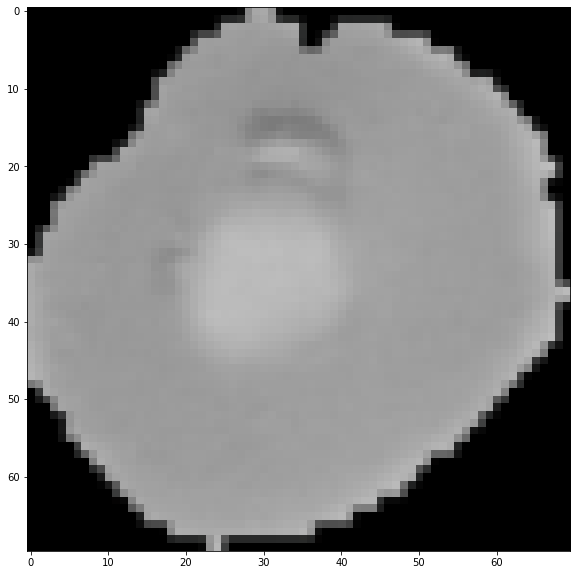

In [33]:
batch_id = 33
data_id = 54
x = model['test_loader'][batch_id][0][data_id]
z = x * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
z = z + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
img = transforms.ToPILImage(mode='RGB')(z)
plt.imshow(img)

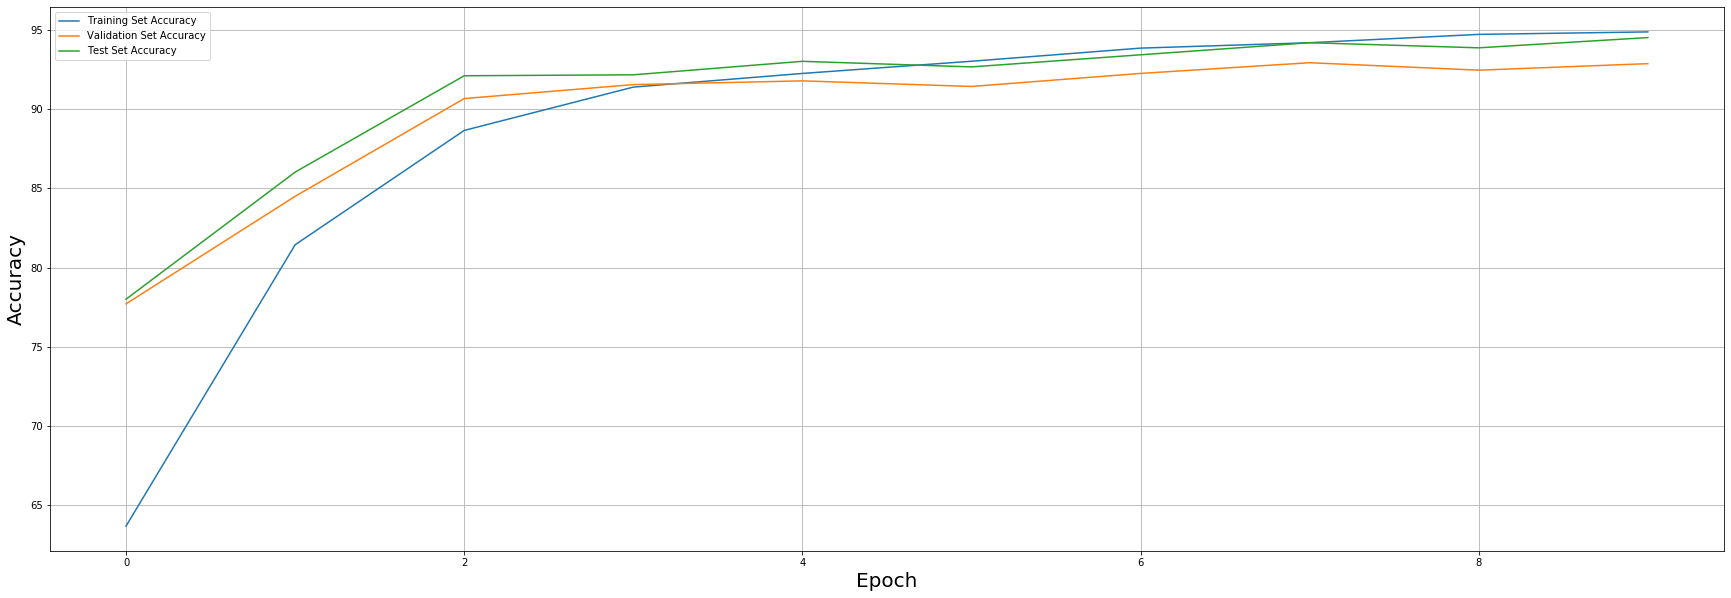

In [35]:
import matplotlib.pyplot as plt

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

l1, = plt.plot(model['training_accuracy_list'] , label= "Training Set Accuracy")
l2, = plt.plot(model['validation_accuracy_list'], label= "Validation Set Accuracy" )
l3, = plt.plot(model['test_accuracy_list'], label= "Test Set Accuracy" )

plt.legend(handles=[l1,l2,l3])
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.autoscale(axis='x',tight=False)
plt.grid(True)
plt.show()

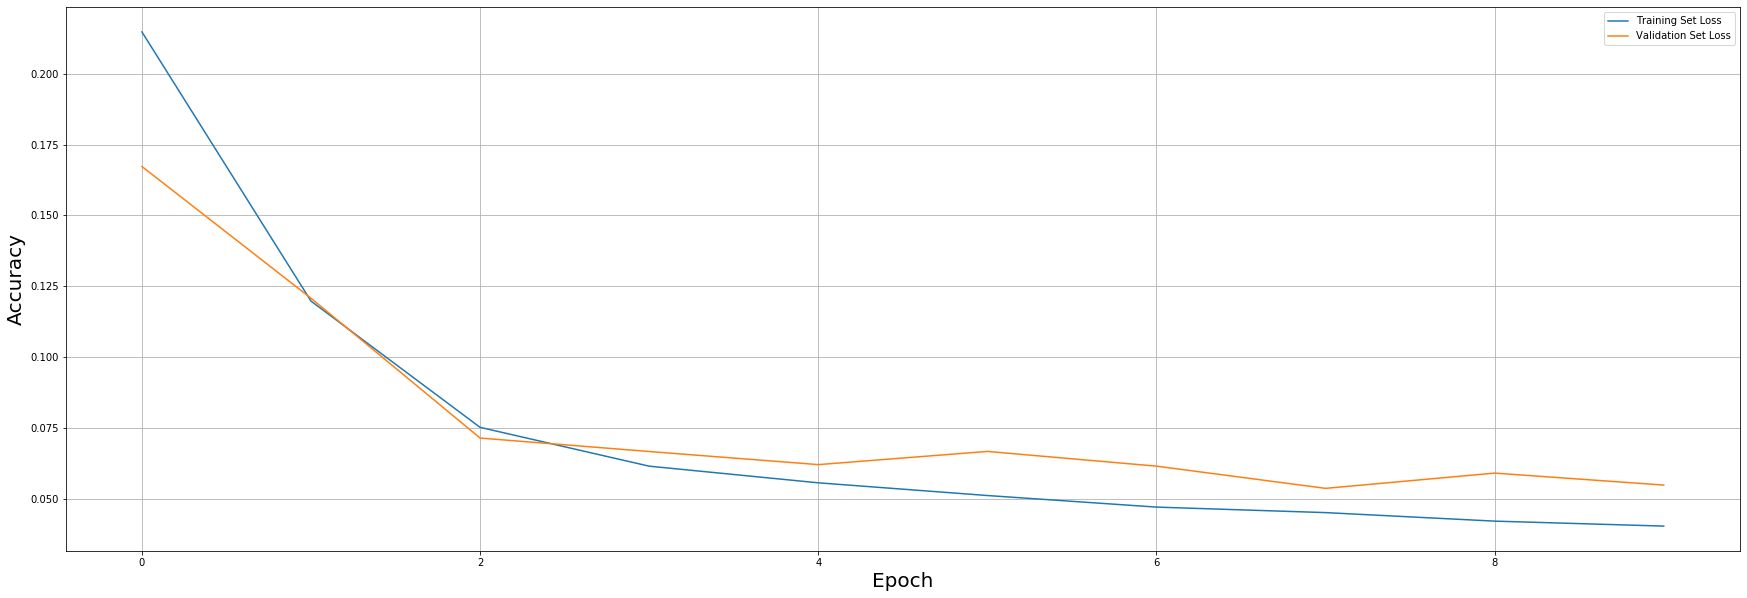

In [36]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

l1, = plt.plot(model['training_loss_list'] , label= "Training Set Loss")
l2, = plt.plot(model['validation_loss_list'], label= "Validation Set Loss" )

plt.legend(handles=[l1,l2])
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.autoscale(axis='x',tight=False)
plt.grid(True)
plt.show()

### Model Loading

In [27]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    return model.eval()


filepath = "Model.pth"
loaded_model = load_checkpoint(filepath)

### Görsel Test

In [ ]:
from PIL import Image
from IPython.display import display

red = Image.open('red1.jpg')
display(red)
red = train_transforms(red)
red = red.unsqueeze(0) #dimension expansion

with torch.no_grad():
    model.eval()
    out = model(red)
print(out)

### One-Hot Encoding

In [ ]:
# some labels
labels = torch.tensor([0,2,4])
print(labels.shape)
labels = labels.reshape(3, 1)
print(labels.shape)

num_classes = 10
one_hot_target = (labels == torch.arange(num_classes).reshape(1, num_classes)).float()
print(one_hot_target,one_hot_target.shape)